Analyze / Process LHE Samples (Signal)

In [1]:
madminer_src_path = '/home/shomiller/madminer'
import sys
import os
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.lhe import LHEReader
from madminer.sampling import combine_and_shuffle
from madminer.plotting import plot_distributions

from scipy.optimize import curve_fit

import madminer.__version__
print( 'MadMiner version: {}'.format(madminer.__version__) )

MadMiner version: 0.4.9


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

# Setup Analysis

To understand the effects of the neutrino momenta, and as another cross-check on the ML results, we'll perform the analysis with two sets of observables:
* Full (including the leading neutrino px, py, pz, e)
* MET (where we have only "physical" observables, e.g., MET, and transverse momenta/masses for the W and the WH system)

We first define the set of observables that go into each of these, then process each set of samples separately.

#### "Full" Observables

In [3]:
observable_names_full = [
    'b1_px', 'b1_py', 'b1_pz', 'b1_e',
    'b2_px', 'b2_py', 'b2_pz', 'b2_e',
    'l_px', 'l_py', 'l_pz', 'l_e',
    'v_px', 'v_py', 'v_pz', 'v_e',
    'pt_b1', 'pt_b2', 'pt_l1', 'pt_l2', 'pt_w', 'pt_h',
    'eta_b1', 'eta_b2', 'eta_l', 'eta_v', 'eta_w', 'eta_h',
    'phi_b1', 'phi_b2', 'phi_l', 'phi_v', 'phi_w', 'phi_h',
    'theta_b1', 'theta_b2', 'theta_l', 'theta_v', 'theta_w', 'theta_h',
    'dphi_bb', 'dphi_lv', 'dphi_wh',
    'm_bb', 'm_lv', 'm_tot',
    'q_l', 'q_v', 'q_b1', 'q_b2',
    'dphi_lb1', 'dphi_lb2', 'dphi_vb1', 'dphi_vb2',
    'dR_bb', 'dR_lv', 'dR_lb1', 'dR_lb2', 'dR_vb1', 'dR_vb2'
]

list_of_observables_full = [
    'j[0].px', 'j[0].py', 'j[0].pz', 'j[0].e',
    'j[1].px', 'j[1].py', 'j[1].pz', 'j[1].e',
    'l[0].px', 'l[0].py', 'l[0].pz', 'l[0].e',
    'v[0].px', 'v[0].py', 'v[0].pz', 'v[0].e',    
    'j[0].pt', 'j[1].pt', 'l[0].pt', 'v[0].pt', '(l[0] + v[0]).pt', '(j[0] + j[1]).pt',
    'j[0].eta', 'j[1].eta', 'l[0].eta', 'v[0].eta', '(l[0] + v[0]).eta', '(j[0] + j[1]).eta',
    'j[0].phi()', 'j[1].phi()', 'l[0].phi()', 'v[0].phi()', '(l[0] + v[0]).phi()', '(j[0] + j[1]).phi()',
    'j[0].theta()', 'j[1].theta()', 'l[0].theta()', 'v[0].theta()', '(l[0] + v[0]).theta()', '(j[0] + j[1]).theta()',
    'j[0].deltaphi(j[1])', 'l[0].deltaphi(v[0])', '(l[0] + v[0]).deltaphi(j[0] + j[1])',
    '(j[0] + j[1]).m', '(l[0] + v[0]).m', '(j[0] + j[1] + l[0] + v[0]).m',
    'l[0].charge', 'v[0].charge', 'j[0].charge', 'j[1].charge',
    'l[0].deltaphi(j[0])', 'l[0].deltaphi(j[1])', 'v[0].deltaphi(j[0])', 'v[0].deltaphi(j[1])',
    'j[0].deltar(j[1])', 'l[0].deltar(v[0])', 'l[0].deltar(j[0])', 'l[0].deltar(j[1])', 'v[0].deltar(j[0])', 'v[0].deltar(j[1])',
]

#### "MET" Observables

In [4]:
observable_names_met = [
    'b1_px', 'b1_py', 'b1_pz', 'b1_e',
    'b2_px', 'b2_py', 'b2_pz', 'b2_e',
    'l_px', 'l_py', 'l_pz', 'l_e',
    'v_px', 'v_py',
    'pt_b1', 'pt_b2', 'pt_l', 'met', 'pt_w', 'pt_h',
    'eta_b1', 'eta_b2', 'eta_l', 'eta_h',
    'phi_b1', 'phi_b2', 'phi_l', 'phi_v', 'phi_w', 'phi_h',
    'theta_b1', 'theta_b2', 'theta_l', 'theta_h',
    'dphi_bb', 'dphi_lv', 'dphi_wh',
    'm_bb', 'mt_lv', 'mt_tot',
    'q_l',
    'dphi_lb1', 'dphi_lb2', 'dphi_vb1', 'dphi_vb2',
    'dR_bb', 'dR_lb1', 'dR_lb2'
]

list_of_observables_met = [
    'j[0].px', 'j[0].py', 'j[0].pz', 'j[0].e',
    'j[1].px', 'j[1].py', 'j[1].pz', 'j[1].e',
    'l[0].px', 'l[0].py', 'l[0].pz', 'l[0].e',
    'met.px', 'met.py',   
    'j[0].pt', 'j[1].pt', 'l[0].pt', 'met.pt', '(l[0] + met).pt', '(j[0] + j[1]).pt',
    'j[0].eta', 'j[1].eta', 'l[0].eta', '(j[0] + j[1]).eta',
    'j[0].phi()', 'j[1].phi()', 'l[0].phi()', 'met.phi()', '(l[0] + met).phi()', '(j[0] + j[1]).phi()',
    'j[0].theta()', 'j[1].theta()', 'l[0].theta()', '(j[0] + j[1]).theta()',
    'j[0].deltaphi(j[1])', 'l[0].deltaphi(met)', '(l[0] + met).deltaphi(j[0] + j[1])',
    '(j[0] + j[1]).m', '(l[0] + met).mt', '(j[0] + j[1] + l[0] + met).mt',
    'l[0].charge',
    'l[0].deltaphi(j[0])', 'l[0].deltaphi(j[1])', 'met.deltaphi(j[0])', 'met.deltaphi(j[1])',
    'j[0].deltar(j[1])', 'l[0].deltar(j[0])', 'l[0].deltar(j[1])'
]

#### Define the Angular Variable, $\cos\theta_W^*$

In [5]:
import skhep.math.vectors
import cmath

def compute_theta_w_star(particles, leptons, photons, jets, met):
    #define the particles (truth)
    #l = p[0].copy()
    #met = p[1].copy()
    #j1 = p[2].copy()
    #j2 = p[3].copy()
    
    #define the particles (smeared)
    l = leptons[0].copy()
    j1 = jets[0].copy()
    j2 = jets[1].copy()
    
    # reconstruct the neutrino pz using the W-mass constraint:
    mw = 80.379
    const = l.mt2 + met.pt**2 - mw**2 - (l + met).pt**2
    a = -l.pz * const
    b = (const*l.pz)**2 - l.mt2*(4*(l.e*met.pt)**2 - const**2)
    c = 2*l.mt2

    # there are two solutions:    
    pnu_z_1 = ((a + cmath.sqrt(b))/c).real
    pnu_z_2 = ((a - cmath.sqrt(b))/c).real
    
    #pick the smaller solution
    if np.abs(pnu_z_1) < pnu_z_2:
        pnu_z = pnu_z_1
    else:
        pnu_z = pnu_z_2
        
    pnu_e = np.sqrt(met.pt**2 + pnu_z**2)
    
    p_nu = skhep.math.vectors.LorentzVector(met.px, met.py, pnu_z, pnu_e)
    
    #Now we need to compute the decay angle, defined as the angle between the charged lepton
    #  in the W rest frame, and the W direction in the WH com frame.
    
    # the W and H momenta:
    pw = l + p_nu
    ph = j1 + j2
    
    #the charged le pton in the W rest frame
    plstar = l.boost((-1.*pw).boostvector)
    
    #the W direction in the WH com frame
    pwcom = pw.boost((-1.*(pw + ph)).boostvector)
    
    #cosine of the angle between the two vectors:
    theta_w_star = plstar.vector.cosdelta(pwcom.vector)
    
    return theta_w_star

## Define Function for Processing with each set of observables

Here we define a function to process the events for each sample with the same settings (modulo a few parameters to be set in the function). This ensures that we're always using the same setup.

The options are:

* `event_path_str`: the path from the main directory (where the notebooks are) that contains the events. E.g., for events in `/home/shomiller/STXS/WH_final/wph_mu_smeftsim/Events/run_01/unweighted_events.lhe.gz`, we set this to `wph_mu_smeftsim`
* `observables`: either `'full'`,`'met'`,`'2d'`, or `'ptw'` (should add the other 1d distributions later)
* `outputfilename`: the `.h5` filename that we want to save to (goes into `data/` directory)
* `nrun` the number of runs there are for that process
* `is_background_process`: for the `is_background` flag, speeds up the analysis of background runs (since the scores are zero)
* `is_ttbar`: whether or not to use the MET resolution derived from $t\bar{t}$ events in 1802.08168 (Fig. 9)

In [58]:
def process_events(event_path_str, observables, outputfilename, nrun, normalize=True, nstart=0, is_background_process = False, cuts=None, list_of_benchmarks=None, morphing_setup_file=None):

    assert observables in ['full','met','2d','ptw','thetaw','2dthetaw','3d', 'metthetaw'], 'input \"observables\" must be either \"full\", \"met\", \"ptw\", \"2d\", \"thetaw\", \"2dthetaw\", or \"3d\"'
        
    # load the MadMiner setup
    if morphing_setup_file == None:
        lhe = LHEReader('data/wh_smeft_setup.h5')
    else:
        lhe = LHEReader('data/{}'.format(morphing_setup_file))
    
    # Smear the mbb peak
    lhe.set_smearing(
        pdgids=[5,-5],
        energy_resolution_abs=0,
        energy_resolution_rel=0.1,
        pt_resolution_abs=None,
        pt_resolution_rel=None,
        eta_resolution_abs=0,
        eta_resolution_rel=0,
        phi_resolution_abs=0,
        phi_resolution_rel=0        
    )
    
    # set up MET smearing -- 
    #for the "Full" kinematics, we'll just smear the neutrino momenta:
    if observables == 'full':
        lhe.set_smearing(
            pdgids=[12,-12,14,-14,16,-16],
            energy_resolution_abs=12.5,
            energy_resolution_rel=0.0,
            pt_resolution_abs=None,
            pt_resolution_rel=None,
            eta_resolution_abs=0,
            eta_resolution_rel=0,
            phi_resolution_abs=0,
            phi_resolution_rel=0
        )
    # for the "MET" kinematics, we'll use the met smearing function
    # we now just have a linear noise function based on the Z->\mu\mu curve in Fig. 8b in 1802.08168
    #     we use this for all of the signal & background samples (the ttbar backgrounds will have higher HT)
    elif observables == 'met' or '2d' or 'ptw' or 'thetaw' or '2dthetaw' or '3d' or 'metthetaw':
        lhe.set_met_noise(abs_=12.5, rel=0.0)
    
    # If the events are all from the same parameter point, we should divide by the number 
    #   of runs done at that point to get the weights correct.
    if normalize:
        kfactor=1./nrun
    else:
        kfactor=1.
    
    # add events
    for run in range(nstart, nstart+nrun):
        run_str = str(run+1)
        if len(run_str) < 2:
            run_str = '0' + run_str
        lhe.add_sample(
            '{}/Events/run_{}/unweighted_events.lhe.gz'.format(event_path_str, run_str),
            sampled_from_benchmark='sm',
            k_factor=kfactor,
            is_background=is_background_process
        )
    
    # add observables
    if observables == 'full':
        for i, name in enumerate(observable_names_full):
            lhe.add_observable( name, list_of_observables_full[i], required=True )
    #otherwise, observables are met:    
    elif observables == 'met':
        for i, name in enumerate(observable_names_met):
            lhe.add_observable( name, list_of_observables_met[i], required=True )
    # 2d: add just ptw and mttot
    elif observables == '2d':
        lhe.add_observable('pt_w', '(l[0] + met).pt', required=True)
        lhe.add_observable('mt_tot','(j[0] + j[1] + l[0] + met).mt', required=True)
    # just ptw
    elif observables == 'ptw':
        lhe.add_observable('pt_w', '(l[0] + met).pt', required=True)
    # just thetaw
    elif observables == 'thetaw':
        lhe.add_observable_from_function( 'thetaw', compute_theta_w_star, required=True )
    # thetaw + ptw
    elif observables == '2dthetaw':
        lhe.add_observable('pt_w', '(l[0] + met).pt', required=True)
        lhe.add_observable_from_function( 'thetaw', compute_theta_w_star, required=True )
    elif observables == '3d':
        lhe.add_observable('pt_w', '(l[0] + met).pt', required=True)
        lhe.add_observable('mt_tot','(j[0] + j[1] + l[0] + met).mt', required=True)
        lhe.add_observable_from_function('thetaw', compute_theta_w_star, required=True )
    elif observables == 'metthetaw':
        for i, name in enumerate(observable_names_met):
            lhe.add_observable( name, list_of_observables_met[i], required=True )
        lhe.add_observable_from_function('thetaw', compute_theta_w_star, required=True )
        
    # add other detector efficiencies...
    lhe.add_efficiency('0.7')
    lhe.add_efficiency('0.7')
    
    #analyse the samples, and save the processed events as an .h5 file for later use
    lhe.analyse_samples()
    
    if is_background_process:
        lhe.save('data/{}/backgrounds/{}'.format(observables, outputfilename))
    else:
        lhe.save('data/{}/signal/{}'.format(observables, outputfilename))

# Analyze Signal Samples:

### Full Observables

In [ ]:
process_events(
    event_path_str='signal_samples/wph_mu_smeftsim', 
    observables='full', 
    outputfilename='wph_mu_smeftsim_lhedata_full.h5', 
    nrun=20,
    is_background_process=False,
)

In [ ]:
process_events(
    event_path_str='signal_samples/wph_e_smeftsim', 
    observables='full', 
    outputfilename='wph_e_smeftsim_lhedata_full.h5', 
    nrun=20,
    is_background_process=False,
)

In [ ]:
process_events(
    event_path_str='signal_samples/wmh_mu_smeftsim', 
    observables='full', 
    outputfilename='wmh_mu_smeftsim_lhedata_full.h5', 
    nrun=20,
    is_background_process=False,
)

In [ ]:
process_events(
    event_path_str='signal_samples/wmh_e_smeftsim', 
    observables='full', 
    outputfilename='wmh_e_smeftsim_lhedata_full.h5', 
    nrun=20,
    is_background_process=False,
)

In [ ]:
_ = plot_distributions(
    filename='data/wph_mu_smeftsim_lhedata_full.h5',
    parameter_points=['sm', 'morphing_basis_vector_1', 'morphing_basis_vector_2', 'morphing_basis_vector_3'],
    line_labels=['SM','BSM 1', 'BSM 2', 'BSM 3'],
    uncertainties=None,
    n_bins=20,
    n_cols=3,
    normalize=False,
    sample_only_from_closest_benchmark=False,
)

### MET Observables

In [7]:
process_events(
    event_path_str='signal_samples/wph_mu_smeftsim', 
    observables='met', 
    outputfilename='wph_mu_smeftsim_lhedata_met.h5', 
    nrun=20,
    is_background_process=False,
)

18:34 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
18:36 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
18:36 madminer.utils.inter WARNING Found 51 negative weights in event. Weights: OrderedDict([(u'sm', -5.7129004e-07), ('1', -5.6342684e-07), ('2', -5.7129004e-07), ('3', -5.7401833e-07), ('4', -5.6342684e-07), ('5', -5.7401833e-07), ('6', -5.6342684e-07), ('7', -5.7129004e-07), ('8', -5.7401833e-07), ('9', -5.7129004e-07), ('10', -5.6905587e-07), ('11', -2.4173799e-07), ('12', -1.4391604e-06), ('13', 1.6061149e-07), ('14', -5.122971e-07), ('15', -3.8202702e-07), ('16', -1.78651e-06), ('17', -7.7465836e-07), ('18', -5.7490972e-07), ('19', -7.8517365e-07), ('20', -5.4549056e-

18:55 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_16/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
18:56 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_17/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
18:58 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_18/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
18:59 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_19/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:00 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_20/unweighted_events.lhe.gz: Calculating 48 observables, requi

In [14]:
process_events(
    event_path_str='signal_samples/wph_e_smeftsim', 
    observables='met', 
    outputfilename='wph_e_smeftsim_lhedata_met.h5', 
    nrun=20,
    is_background_process=False,
)

20:50 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_e_smeftsim/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
20:52 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_e_smeftsim/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
20:53 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_e_smeftsim/Events/run_03/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
20:55 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_e_smeftsim/Events/run_04/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
20:56 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_e_smeftsim/Events/run_05/unweighted_events.lhe.gz: Calculating 48 observables, requiring 

In [20]:
process_events(
    event_path_str='signal_samples/wmh_mu_smeftsim', 
    observables='met', 
    outputfilename='wmh_mu_smeftsim_lhedata_met.h5', 
    nrun=20,
    is_background_process=False,
)

23:12 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
23:13 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
23:14 madminer.utils.inter WARNING Found 2 negative weights in event. Weights: OrderedDict([(u'sm', 3.7237842e-07), ('1', 3.9736225e-07), ('2', 3.7237842e-07), ('3', 3.4883742e-07), ('4', 3.9736225e-07), ('5', 3.4883742e-07), ('6', 3.9736225e-07), ('7', 3.7237842e-07), ('8', 3.4883742e-07), ('9', 3.7237842e-07), ('10', 3.9316054e-07), ('11', 1.8795728e-07), ('12', 6.9857818e-07), ('13', -4.536149e-08), ('14', 3.1510745e-07), ('15', 2.2070769e-07), ('16', 3.0963972e-07), ('17', 4.8773351e-07), ('18', 3.2331401e-07), ('19', 5.157164e-07), ('20', 3.8656757e-07), ('21', 4.71729

23:33 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_16/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
23:34 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_17/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
23:36 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_18/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
23:37 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_19/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
23:38 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_20/unweighted_events.lhe.gz: Calculating 48 observables, requi

In [ ]:
process_events(
    event_path_str='signal_samples/wmh_e_smeftsim', 
    observables='met', 
    outputfilename='wmh_e_smeftsim_lhedata_met.h5', 
    nrun=20,
    is_background_process=False,
)

19:02 madminer.analysis    INFO    Loading data from data/wph_mu_smeftsim_lhedata_met.h5
19:02 madminer.analysis    INFO    Found 4 parameters
19:02 madminer.analysis    INFO    Found 33 nuisance parameters
19:02 madminer.analysis    INFO    Found 54 benchmarks, of which 15 physical
19:02 madminer.analysis    INFO    Found 48 observables
19:02 madminer.analysis    INFO    Found 1000000 events
19:02 madminer.analysis    INFO      1000000 signal events sampled from benchmark sm
19:02 madminer.analysis    INFO    Found morphing setup with 15 components
19:02 madminer.analysis    INFO    Found nuisance morphing setup
19:02 madminer.plotting    WARNING Removed 3 / 1000000 events with negative weights
/home/shomiller/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


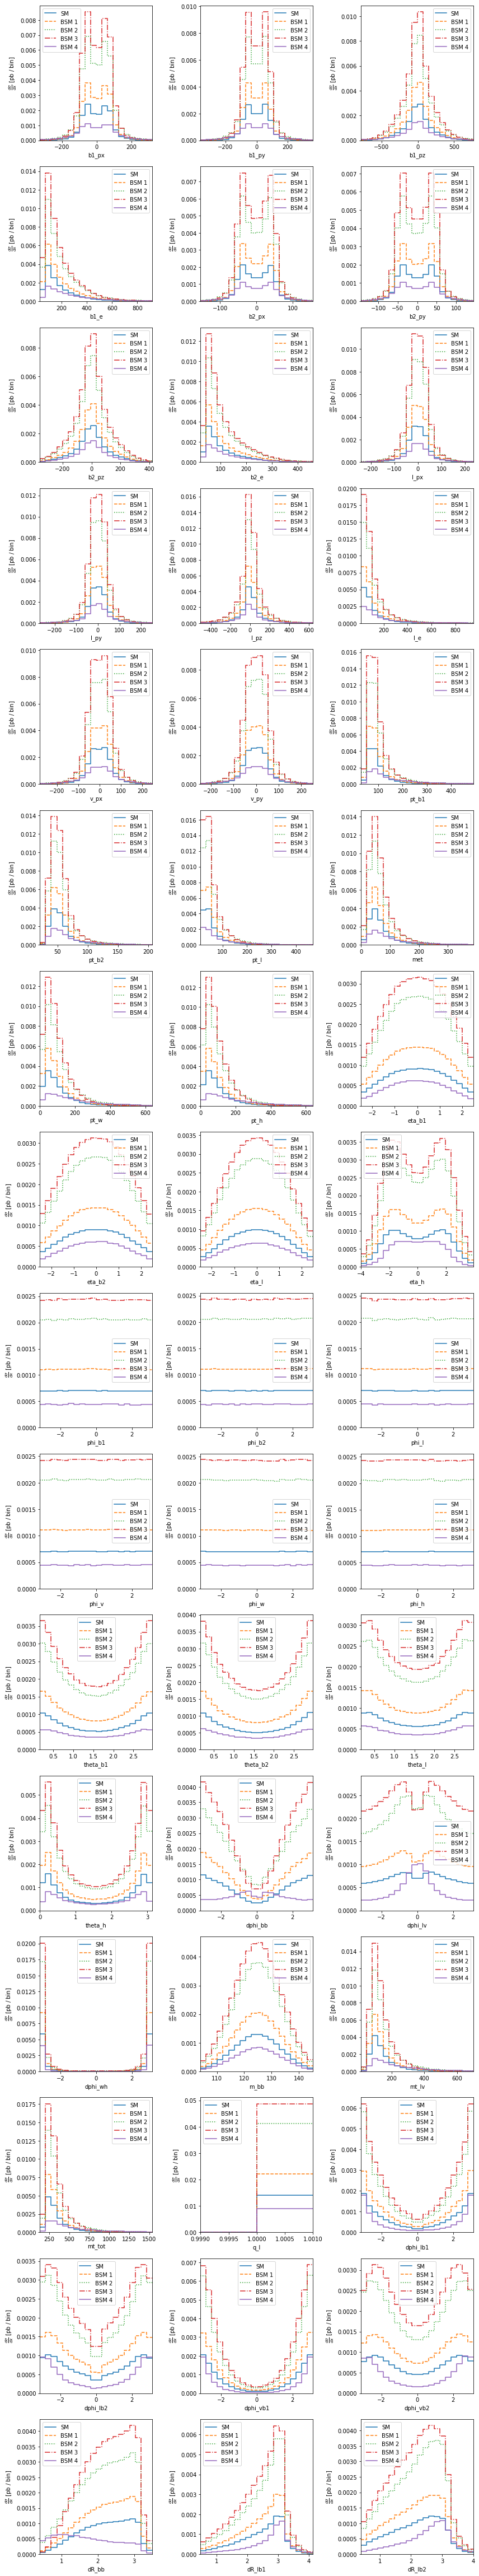

In [8]:
_ = plot_distributions(
    filename='data/wph_mu_smeftsim_lhedata_met.h5',
    parameter_points=['sm', 'morphing_basis_vector_1', 'morphing_basis_vector_2', 'morphing_basis_vector_3', 'morphing_basis_vector_4' ],
    line_labels=['SM','BSM 1', 'BSM 2', 'BSM 3', 'BSM 4'],
    uncertainties=None,
    n_bins=20,
    n_cols=3,
    normalize=False,
    sample_only_from_closest_benchmark=False,
)

### MET + $\cos\theta_W^*$

In [60]:
process_events(
    event_path_str='signal_samples/wph_mu_smeftsim', 
    observables='metthetaw', 
    outputfilename='wph_mu_smeftsim_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=False,
)

08:01 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
08:02 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
08:03 madminer.utils.inter WARNING Found 51 negative weights in event. Weights: OrderedDict([(u'sm', -5.7129004e-07), ('1', -5.6342684e-07), ('2', -5.7129004e-07), ('3', -5.7401833e-07), ('4', -5.6342684e-07), ('5', -5.7401833e-07), ('6', -5.6342684e-07), ('7', -5.7129004e-07), ('8', -5.7401833e-07), ('9', -5.7129004e-07), ('10', -5.6905587e-07), ('11', -2.4173799e-07), ('12', -1.4391604e-06), ('13', 1.6061149e-07), ('14', -5.122971e-07), ('15', -3.8202702e-07), ('16', -1.78651e-06), ('17', -7.7465836e-07), ('18', -5.7490972e-07), ('19', -7.8517365e-07), ('20', -5.4549056e-

08:24 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_16/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
08:25 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_17/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
08:27 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_18/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
08:28 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_19/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
08:30 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_mu_smeftsim/Events/run_20/unweighted_events.lhe.gz: Calculating 49 observables, requi

In [66]:
process_events(
    event_path_str='signal_samples/wph_e_smeftsim', 
    observables='metthetaw', 
    outputfilename='wph_e_smeftsim_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=False,
)

12:15 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_e_smeftsim/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
12:16 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_e_smeftsim/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
12:18 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_e_smeftsim/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
12:19 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_e_smeftsim/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
12:21 madminer.lhe         INFO    Analysing LHE sample signal_samples/wph_e_smeftsim/Events/run_05/unweighted_events.lhe.gz: Calculating 49 observables, requiring 

In [75]:
process_events(
    event_path_str='signal_samples/wmh_mu_smeftsim', 
    observables='metthetaw', 
    outputfilename='wmh_mu_smeftsim_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=False,
)

17:25 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
17:27 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
17:27 madminer.utils.inter WARNING Found 2 negative weights in event. Weights: OrderedDict([(u'sm', 3.7237842e-07), ('1', 3.9736225e-07), ('2', 3.7237842e-07), ('3', 3.4883742e-07), ('4', 3.9736225e-07), ('5', 3.4883742e-07), ('6', 3.9736225e-07), ('7', 3.7237842e-07), ('8', 3.4883742e-07), ('9', 3.7237842e-07), ('10', 3.9316054e-07), ('11', 1.8795728e-07), ('12', 6.9857818e-07), ('13', -4.536149e-08), ('14', 3.1510745e-07), ('15', 2.2070769e-07), ('16', 3.0963972e-07), ('17', 4.8773351e-07), ('18', 3.2331401e-07), ('19', 5.157164e-07), ('20', 3.8656757e-07), ('21', 4.71729

17:49 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_16/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
17:51 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_17/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
17:52 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_18/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
17:54 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_19/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
17:56 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_mu_smeftsim/Events/run_20/unweighted_events.lhe.gz: Calculating 49 observables, requi

In [81]:
process_events(
    event_path_str='signal_samples/wmh_e_smeftsim', 
    observables='metthetaw', 
    outputfilename='wmh_e_smeftsim_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=False,
)

22:53 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_e_smeftsim/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
22:54 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_e_smeftsim/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
22:55 madminer.utils.inter WARNING Found 2 negative weights in event. Weights: OrderedDict([(u'sm', 3.7237842e-07), ('1', 3.9736225e-07), ('2', 3.7237842e-07), ('3', 3.4883742e-07), ('4', 3.9736225e-07), ('5', 3.4883742e-07), ('6', 3.9736225e-07), ('7', 3.7237842e-07), ('8', 3.4883742e-07), ('9', 3.7237842e-07), ('10', 3.9316054e-07), ('11', 1.8795728e-07), ('12', 6.9857818e-07), ('13', -4.536149e-08), ('14', 3.1510745e-07), ('15', 2.2070769e-07), ('16', 3.0963972e-07), ('17', 4.8773351e-07), ('18', 3.2331401e-07), ('19', 5.157164e-07), ('20', 3.8656757e-07), ('21', 4.7172979

23:16 madminer.lhe         INFO    Analysing LHE sample signal_samples/wmh_e_smeftsim/Events/run_16/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
23:17 madminer.utils.inter WARNING Found 1 negative weights in event. Weights: OrderedDict([(u'sm', 3.7159282e-07), ('1', 3.9945007e-07), ('2', 3.7159282e-07), ('3', 3.4609524e-07), ('4', 3.9945007e-07), ('5', 3.4609524e-07), ('6', 3.9945007e-07), ('7', 3.7159282e-07), ('8', 3.4609524e-07), ('9', 3.7159282e-07), ('10', 3.8507379e-07), ('11', 1.8502388e-07), ('12', 5.8920511e-07), ('13', -1.7160569e-08), ('14', 3.1570957e-07), ('15', 2.6112226e-07), ('16', 3.7793146e-07), ('17', 4.9236887e-07), ('18', 3.2717433e-07), ('19', 4.7339393e-07), ('20', 3.8076371e-07), ('21', 4.5010387e-07), ('22', 1.0103269e-07), ('23', 2.919352e-07), ('24', 3.7471765e-07), ('25', 1.6000813e-07), ('26', 4.1690639e-07), ('27', 4.9897657e-07), ('28', 4.9418452e-07), ('29', 3.8466621e-07), ('30', 3.8241645e

# Analyze Backgrounds

### Full Observables

#### $Wb\bar{b}$

In [ ]:
process_events(
    event_path_str='background_samples/wpbb_mu_background', 
    observables='full', 
    outputfilename='wpbb_mu_background_lhedata_full.h5', 
    nrun=40,
    is_background_process=True,
)

In [41]:
process_events(
    event_path_str='background_samples/wpbb_e_background', 
    observables='full', 
    outputfilename='wpbb_e_background_lhedata_full.h5', 
    nrun=40,
    is_background_process=True,
)

07:40 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
07:42 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
07:43 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
07:45 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
07:46 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_05/unweighted_events.lhe.gz: Cal

08:33 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_34/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
08:35 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_35/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
08:36 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_36/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
08:38 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_37/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
08:39 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_38/unweighted_events.lhe.gz: Cal

In [50]:
process_events(
    event_path_str='background_samples/wmbb_mu_background', 
    observables='full', 
    outputfilename='wmbb_mu_background_lhedata_full.h5', 
    nrun=40,
    is_background_process=True,
)

12:09 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
12:11 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
12:13 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
12:16 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
12:18 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_05/unweighted_events.lhe.gz

13:31 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_39/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
13:33 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_40/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
13:36 madminer.lhe         INFO    Analysed number of events per sampling benchmark:
13:36 madminer.lhe         INFO      2000000 from backgrounds


In [55]:
process_events(
    event_path_str='background_samples/wmbb_e_background', 
    observables='full', 
    outputfilename='wmbb_e_background_lhedata_full.h5', 
    nrun=40,
    is_background_process=True,
)

15:58 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
16:00 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
16:03 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
16:05 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
16:07 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_05/unweighted_events.lhe.gz: Cal

17:21 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_39/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
17:23 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_40/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
17:25 madminer.lhe         INFO    Analysed number of events per sampling benchmark:
17:25 madminer.lhe         INFO      2000000 from backgrounds


#### $tb$

In [42]:
process_events(
    event_path_str='background_samples/tpb_mu_background', 
    observables='full', 
    outputfilename='tpb_mu_background_lhedata_full.h5', 
    nrun=20,
    is_background_process=True,
)

08:45 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
08:46 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
08:48 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
08:50 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
08:52 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_05/unweighted_events.lhe.gz: Cal

In [47]:
process_events(
    event_path_str='background_samples/tpb_e_background', 
    observables='full', 
    outputfilename='tpb_e_background_lhedata_full.h5', 
    nrun=20,
    is_background_process=True,
)

10:32 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
10:35 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
10:37 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
10:39 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
10:41 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_05/unweighted_events.lhe.gz: Calculat

In [52]:
process_events(
    event_path_str='background_samples/tmb_mu_background', 
    observables='full', 
    outputfilename='tmb_mu_background_lhedata_full.h5', 
    nrun=20,
    is_background_process=True,
)

14:22 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
14:24 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
14:26 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
14:28 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
14:30 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_05/unweighted_events.lhe.gz: Cal

In [56]:
process_events(
    event_path_str='background_samples/tmb_e_background', 
    observables='full', 
    outputfilename='tmb_e_background_lhedata_full.h5', 
    nrun=20,
    is_background_process=True,
)

17:25 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_e_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
17:28 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_e_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
17:30 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_e_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
17:32 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_e_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
17:34 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_e_background/Events/run_05/unweighted_events.lhe.gz: Calculat

#### $t\bar{t}$

In [45]:
process_events(
    event_path_str='background_samples/tt_mupjj_background', 
    observables='full', 
    outputfilename='tt_mupjj_background_lhedata_full.h5', 
    nrun=20,
    is_background_process=True,
)

09:33 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
09:35 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
09:37 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
09:40 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
09:42 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_05/unweighted_events.l

In [48]:
process_events(
    event_path_str='background_samples/tt_epjj_background', 
    observables='full', 
    outputfilename='tt_epjj_background_lhedata_full.h5', 
    nrun=20,
    is_background_process=True,
)

11:17 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
11:19 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
11:21 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
11:24 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
11:26 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_05/unweighted_events.lhe.gz

In [51]:
process_events(
    event_path_str='background_samples/tt_mumjj_background', 
    observables='full', 
    outputfilename='tt_mumjj_background_lhedata_full.h5', 
    nrun=20,
    is_background_process=True,
)

13:36 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mumjj_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
13:38 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mumjj_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
13:40 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mumjj_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
13:43 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mumjj_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
13:45 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mumjj_background/Events/run_05/unweighted_events.l

In [54]:
process_events(
    event_path_str='background_samples/tt_emjj_background', 
    observables='full', 
    outputfilename='tt_emjj_background_lhedata_full.h5', 
    nrun=20,
    is_background_process=True,
)

15:12 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_emjj_background/Events/run_01/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
15:15 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_emjj_background/Events/run_02/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
15:17 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_emjj_background/Events/run_03/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
15:19 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_emjj_background/Events/run_04/unweighted_events.lhe.gz: Calculating 60 observables, requiring 0 selection cuts, using 2 efficiency factors
15:22 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_emjj_background/Events/run_05/unweighted_events.lhe.gz

### MET Observables

#### $Wb\bar{b}$

In [9]:
process_events(
    event_path_str='background_samples/wpbb_mu_background', 
    observables='met', 
    outputfilename='wpbb_mu_background_lhedata_met.h5', 
    nrun=40,
    is_background_process=True,
)

19:02 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:04 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:05 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:06 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_04/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:08 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_05/unweighted_events.lhe.gz

19:46 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_34/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:47 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_35/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:48 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_36/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:50 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_37/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:51 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_38/unweighted_events.lhe.gz

In [15]:
process_events(
    event_path_str='background_samples/wpbb_e_background', 
    observables='met', 
    outputfilename='wpbb_e_background_lhedata_met.h5', 
    nrun=40,
    is_background_process=True,
)

21:18 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
21:20 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
21:21 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_03/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
21:22 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_04/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
21:24 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_05/unweighted_events.lhe.gz: Cal

22:02 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_34/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:03 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_35/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:04 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_36/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:05 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_37/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:07 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_38/unweighted_events.lhe.gz: Cal

In [ ]:
process_events(
    event_path_str='background_samples/wmbb_mu_background', 
    observables='met', 
    outputfilename='wmbb_mu_background_lhedata_met.h5', 
    nrun=40,
    is_background_process=True,
)

23:40 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
23:41 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
23:42 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
23:44 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_04/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
23:45 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_05/unweighted_events.lhe.gz

00:31 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_39/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
00:32 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_40/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
00:33 madminer.lhe         INFO    Analysed number of events per sampling benchmark:
00:33 madminer.lhe         INFO      2000000 from backgrounds


In [ ]:
process_events(
    event_path_str='background_samples/wmbb_e_background', 
    observables='met', 
    outputfilename='wmbb_e_background_lhedata_met.h5', 
    nrun=40,
    is_background_process=True,
)

#### $tb$

In [10]:
process_events(
    event_path_str='background_samples/tpb_mu_background', 
    observables='met', 
    outputfilename='tpb_mu_background_lhedata_met.h5', 
    nrun=20,
    is_background_process=True,
)

19:55 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:56 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:58 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
19:59 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_04/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
20:00 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_05/unweighted_events.lhe.gz: Cal

In [16]:
process_events(
    event_path_str='background_samples/tpb_e_background', 
    observables='met', 
    outputfilename='tpb_e_background_lhedata_met.h5', 
    nrun=20,
    is_background_process=True,
)

22:11 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:12 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:14 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_03/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:15 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_04/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:16 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_05/unweighted_events.lhe.gz: Calculat

In [39]:
process_events(
    event_path_str='background_samples/tmb_mu_background', 
    observables='met', 
    outputfilename='tmb_mu_background_lhedata_met.h5', 
    nrun=20,
    is_background_process=True,
)

07:30 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
07:32 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
07:33 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors


KeyboardInterrupt: 

In [ ]:
process_events(
    event_path_str='background_samples/tmb_e_background', 
    observables='met', 
    outputfilename='tmb_e_background_lhedata_met.h5', 
    nrun=20,
    is_background_process=True,
)

#### $t\bar{t}$

In [11]:
process_events(
    event_path_str='background_samples/tt_mupjj_background', 
    observables='met', 
    outputfilename='tt_mupjj_background_lhedata_met.h5', 
    nrun=20,
    is_background_process=True,
)

20:21 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
20:23 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
20:24 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_03/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
20:26 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_04/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
20:27 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_05/unweighted_events.l

In [17]:
process_events(
    event_path_str='background_samples/tt_epjj_background', 
    observables='met', 
    outputfilename='tt_epjj_background_lhedata_met.h5', 
    nrun=20,
    is_background_process=True,
)

22:38 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_01/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:39 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_02/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:41 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_03/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:42 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_04/unweighted_events.lhe.gz: Calculating 48 observables, requiring 0 selection cuts, using 2 efficiency factors
22:44 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_05/unweighted_events.lhe.gz

In [ ]:
process_events(
    event_path_str='background_samples/tt_mumjj_background', 
    observables='met', 
    outputfilename='tt_mumjj_background_lhedata_met.h5', 
    nrun=20,
    is_background_process=True,
)

In [ ]:
process_events(
    event_path_str='background_samples/tt_emjj_background', 
    observables='met', 
    outputfilename='tt_emjj_background_lhedata_met.h5', 
    nrun=20,
    is_background_process=True,
)

### MET + $\cos\theta_W^*$

#### $Wb\bar{b}$

In [61]:
process_events(
    event_path_str='background_samples/wpbb_mu_background', 
    observables='metthetaw', 
    outputfilename='wpbb_mu_background_lhedata_metthetaw.h5', 
    nrun=40,
    is_background_process=True,
)

08:31 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
08:33 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
08:34 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
08:36 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
08:37 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_05/unweighted_events.lhe.gz

09:21 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_34/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
09:23 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_35/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
09:24 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_36/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
09:26 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_37/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
09:27 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_mu_background/Events/run_38/unweighted_events.lhe.gz

In [67]:
process_events(
    event_path_str='background_samples/wpbb_e_background', 
    observables='metthetaw', 
    outputfilename='wpbb_e_background_lhedata_metthetaw.h5', 
    nrun=40,
    is_background_process=True,
)

12:45 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
12:47 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
12:49 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
12:50 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
12:52 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_05/unweighted_events.lhe.gz: Cal

13:36 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_34/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
13:37 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_35/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
13:39 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_36/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
13:40 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_37/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
13:42 madminer.lhe         INFO    Analysing LHE sample background_samples/wpbb_e_background/Events/run_38/unweighted_events.lhe.gz: Cal

In [76]:
process_events(
    event_path_str='background_samples/wmbb_mu_background', 
    observables='metthetaw', 
    outputfilename='wmbb_mu_background_lhedata_metthetaw.h5', 
    nrun=40,
    is_background_process=True,
)

17:57 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
17:59 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
18:00 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
18:02 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
18:03 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_05/unweighted_events.lhe.gz

18:59 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_39/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
19:00 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_mu_background/Events/run_40/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
19:02 madminer.lhe         INFO    Analysed number of events per sampling benchmark:
19:02 madminer.lhe         INFO      2000000 from backgrounds


In [82]:
process_events(
    event_path_str='background_samples/wmbb_e_background', 
    observables='metthetaw', 
    outputfilename='wmbb_e_background_lhedata_metthetaw.h5', 
    nrun=40,
    is_background_process=True,
)

23:24 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
23:26 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
23:27 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
23:29 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
23:30 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_05/unweighted_events.lhe.gz: Cal

00:21 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_39/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
00:22 madminer.lhe         INFO    Analysing LHE sample background_samples/wmbb_e_background/Events/run_40/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
00:24 madminer.lhe         INFO    Analysed number of events per sampling benchmark:
00:24 madminer.lhe         INFO      2000000 from backgrounds


#### $tb$

In [62]:
process_events(
    event_path_str='background_samples/tpb_mu_background', 
    observables='metthetaw', 
    outputfilename='tpb_mu_background_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=True,
)

09:32 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
09:34 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
09:35 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
09:37 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
09:38 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_mu_background/Events/run_05/unweighted_events.lhe.gz: Cal

In [68]:
process_events(
    event_path_str='background_samples/tpb_e_background', 
    observables='metthetaw', 
    outputfilename='tpb_e_background_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=True,
)

13:46 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
13:48 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
13:49 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
13:51 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
13:52 madminer.lhe         INFO    Analysing LHE sample background_samples/tpb_e_background/Events/run_05/unweighted_events.lhe.gz: Calculat

In [78]:
process_events(
    event_path_str='background_samples/tmb_mu_background', 
    observables='metthetaw', 
    outputfilename='tmb_mu_background_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=True,
)

21:47 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
21:49 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
21:50 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
21:52 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
21:53 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_mu_background/Events/run_05/unweighted_events.lhe.gz: Cal

In [83]:
process_events(
    event_path_str='background_samples/tmb_e_background', 
    observables='metthetaw', 
    outputfilename='tmb_e_background_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=True,
)

00:24 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_e_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
00:25 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_e_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
00:27 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_e_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
00:28 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_e_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
00:29 madminer.lhe         INFO    Analysing LHE sample background_samples/tmb_e_background/Events/run_05/unweighted_events.lhe.gz: Calculat

#### $t\bar{t}$

In [63]:
process_events(
    event_path_str='background_samples/tt_mupjj_background', 
    observables='metthetaw', 
    outputfilename='tt_mupjj_background_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=True,
)

10:02 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
10:04 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
10:06 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
10:07 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
10:09 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mupjj_background/Events/run_05/unweighted_events.l

In [69]:
process_events(
    event_path_str='background_samples/tt_epjj_background', 
    observables='metthetaw', 
    outputfilename='tt_epjj_background_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=True,
)

14:17 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
14:18 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
14:20 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
14:21 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
14:23 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_epjj_background/Events/run_05/unweighted_events.lhe.gz

In [79]:
process_events(
    event_path_str='background_samples/tt_mumjj_background', 
    observables='metthetaw', 
    outputfilename='tt_mumjj_background_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=True,
)

22:18 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mumjj_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
22:19 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mumjj_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
22:21 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mumjj_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
22:22 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mumjj_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
22:24 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_mumjj_background/Events/run_05/unweighted_events.l

In [84]:
process_events(
    event_path_str='background_samples/tt_emjj_background', 
    observables='metthetaw', 
    outputfilename='tt_emjj_background_lhedata_metthetaw.h5', 
    nrun=20,
    is_background_process=True,
)

00:53 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_emjj_background/Events/run_01/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
00:55 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_emjj_background/Events/run_02/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
00:56 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_emjj_background/Events/run_03/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
00:58 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_emjj_background/Events/run_04/unweighted_events.lhe.gz: Calculating 49 observables, requiring 0 selection cuts, using 2 efficiency factors
01:00 madminer.lhe         INFO    Analysing LHE sample background_samples/tt_emjj_background/Events/run_05/unweighted_events.lhe.gz

# Combine Signal and Background Samples for ML Runs

Now we shuffle & combine the different samples from signal and background events into one large `.h5` file that we can use for training/testing the neural network approach.

### Full Observables

In [46]:
lhedatafile_wph_mu_wbkgs_full = 'data/full/wph_mu_wbkgs_lhedata_full.h5'

combine_and_shuffle(
    [ 'data/full/signal/wph_mu_smeftsim_lhedata_full.h5', 
    'data/full/backgrounds/wpbb_mu_background_lhedata_full.h5', 
    'data/full/backgrounds/tpb_mu_background_lhedata_full.h5',
    'data/full/backgrounds/tt_mupjj_background_lhedata_full.h5'],
    lhedatafile_wph_mu_wbkgs_full
)

10:27 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
10:27 madminer.sampling    INFO    Copying setup from data/full/signal/wph_mu_smeftsim_lhedata_full.h5 to data/full/wph_mu_wbkgs_lhedata_full.h5
10:27 madminer.sampling    INFO    Loading samples from file 1 / 4 at data/full/signal/wph_mu_smeftsim_lhedata_full.h5, multiplying weights with k factor 1.0
10:27 madminer.sampling    INFO    Loading samples from file 2 / 4 at data/full/backgrounds/wpbb_mu_background_lhedata_full.h5, multiplying weights with k factor 1.0
10:29 madminer.sampling    INFO    Loading samples from file 3 / 4 at data/full/backgrounds/tpb_mu_background_lhedata_full.h5, multiplying weights with k factor 1.0
10:30 madminer.sampling    INFO    Loading samples from file 4 /

In [49]:
lhedatafile_wph_e_wbkgs_full = 'data/full/wph_e_wbkgs_lhedata_full.h5'

combine_and_shuffle(
    [ 'data/full/signal/wph_e_smeftsim_lhedata_full.h5', 
    'data/full/backgrounds/wpbb_e_background_lhedata_full.h5', 
    'data/full/backgrounds/tpb_e_background_lhedata_full.h5',
    'data/full/backgrounds/tt_epjj_background_lhedata_full.h5'],
    lhedatafile_wph_e_wbkgs_full
)

12:03 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
12:03 madminer.sampling    INFO    Copying setup from data/full/signal/wph_e_smeftsim_lhedata_full.h5 to data/full/wph_e_wbkgs_lhedata_full.h5
12:03 madminer.sampling    INFO    Loading samples from file 1 / 4 at data/full/signal/wph_e_smeftsim_lhedata_full.h5, multiplying weights with k factor 1.0
12:03 madminer.sampling    INFO    Loading samples from file 2 / 4 at data/full/backgrounds/wpbb_e_background_lhedata_full.h5, multiplying weights with k factor 1.0
12:05 madminer.sampling    INFO    Loading samples from file 3 / 4 at data/full/backgrounds/tpb_e_background_lhedata_full.h5, multiplying weights with k factor 1.0
12:07 madminer.sampling    INFO    Loading samples from file 4 / 4 at

In [53]:
lhedatafile_wmh_mu_wbkgs_full = 'data/full/wmh_mu_wbkgs_lhedata_full.h5'

combine_and_shuffle(
    [ 'data/full/signal/wmh_mu_smeftsim_lhedata_full.h5', 
    'data/full/backgrounds/wmbb_mu_background_lhedata_full.h5', 
    'data/full/backgrounds/tmb_mu_background_lhedata_full.h5',
    'data/full/backgrounds/tt_mumjj_background_lhedata_full.h5'],
    lhedatafile_wmh_mu_wbkgs_full
)

15:05 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
15:05 madminer.sampling    INFO    Copying setup from data/full/signal/wmh_mu_smeftsim_lhedata_full.h5 to data/full/wmh_mu_wbkgs_lhedata_full.h5
15:05 madminer.sampling    INFO    Loading samples from file 1 / 4 at data/full/signal/wmh_mu_smeftsim_lhedata_full.h5, multiplying weights with k factor 1.0
15:06 madminer.sampling    INFO    Loading samples from file 2 / 4 at data/full/backgrounds/wmbb_mu_background_lhedata_full.h5, multiplying weights with k factor 1.0
15:08 madminer.sampling    INFO    Loading samples from file 3 / 4 at data/full/backgrounds/tmb_mu_background_lhedata_full.h5, multiplying weights with k factor 1.0
15:10 madminer.sampling    INFO    Loading samples from file 4 /

In [57]:
lhedatafile_wmh_e_wbkgs_full = 'data/full/wmh_e_wbkgs_lhedata_full.h5'

combine_and_shuffle(
    [ 'data/full/signal/wmh_e_smeftsim_lhedata_full.h5', 
    'data/full/backgrounds/wmbb_e_background_lhedata_full.h5', 
    'data/full/backgrounds/tmb_e_background_lhedata_full.h5',
    'data/full/backgrounds/tt_emjj_background_lhedata_full.h5'],
    lhedatafile_wmh_e_wbkgs_full
)

18:03 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
18:03 madminer.sampling    INFO    Copying setup from data/full/signal/wmh_e_smeftsim_lhedata_full.h5 to data/full/wmh_e_wbkgs_lhedata_full.h5
18:03 madminer.sampling    INFO    Loading samples from file 1 / 4 at data/full/signal/wmh_e_smeftsim_lhedata_full.h5, multiplying weights with k factor 1.0
18:03 madminer.sampling    INFO    Loading samples from file 2 / 4 at data/full/backgrounds/wmbb_e_background_lhedata_full.h5, multiplying weights with k factor 1.0
18:05 madminer.sampling    INFO    Loading samples from file 3 / 4 at data/full/backgrounds/tmb_e_background_lhedata_full.h5, multiplying weights with k factor 1.0
18:06 madminer.sampling    INFO    Loading samples from file 4 / 4 at

### MET Observables

In [12]:
lhedatafile_wph_mu_wbkgs_met = 'data/met/wph_mu_wbkgs_lhedata_met.h5'

combine_and_shuffle(
    [ 'data/met/signal/wph_mu_smeftsim_lhedata_met.h5', 
    'data/met/backgrounds/wpbb_mu_background_lhedata_met.h5', 
    'data/met/backgrounds/tpb_mu_background_lhedata_met.h5',
    'data/met/backgrounds/tt_mupjj_background_lhedata_met.h5'],
    lhedatafile_wph_mu_wbkgs_met
)

20:49 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
20:49 madminer.sampling    INFO    Copying setup from data/wph_mu_smeftsim_lhedata_met.h5 to data/wph_mu_wbkgs_lhedata_met.h5
20:49 madminer.sampling    INFO    Loading samples from file 1 / 4 at data/wph_mu_smeftsim_lhedata_met.h5, multiplying weights with k factor 1.0
20:49 madminer.sampling    INFO    Loading samples from file 2 / 4 at data/wpbb_mu_background_lhedata_met.h5, multiplying weights with k factor 1.0
20:49 madminer.sampling    INFO    Loading samples from file 3 / 4 at data/tpb_mu_background_lhedata_met.h5, multiplying weights with k factor 1.0
20:50 madminer.sampling    INFO    Loading samples from file 4 / 4 at data/tt_mupjj_background_lhedata_met.h5, multiplying weights w

In [18]:
lhedatafile_wph_e_wbkgs_met = 'data/met/wph_e_wbkgs_lhedata_met.h5'

combine_and_shuffle(
    [ 'data/met/signal/wph_e_smeftsim_lhedata_met.h5', 
    'data/met/backgrounds/wpbb_e_background_lhedata_met.h5', 
    'data/met/backgrounds/tpb_e_background_lhedata_met.h5',
    'data/met/backgrounds/tt_epjj_background_lhedata_met.h5'],
    lhedatafile_wph_e_wbkgs_met
)

23:06 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
23:06 madminer.sampling    INFO    Copying setup from data/wph_e_smeftsim_lhedata_met.h5 to data/wph_e_wbkgs_lhedata_met.h5
23:06 madminer.sampling    INFO    Loading samples from file 1 / 4 at data/wph_e_smeftsim_lhedata_met.h5, multiplying weights with k factor 1.0
23:07 madminer.sampling    INFO    Loading samples from file 2 / 4 at data/wpbb_e_background_lhedata_met.h5, multiplying weights with k factor 1.0
23:07 madminer.sampling    INFO    Loading samples from file 3 / 4 at data/tpb_e_background_lhedata_met.h5, multiplying weights with k factor 1.0
23:08 madminer.sampling    INFO    Loading samples from file 4 / 4 at data/tt_epjj_background_lhedata_met.h5, multiplying weights with k 

In [ ]:
lhedatafile_wmh_mu_wbkgs_met = 'data/met/wmh_mu_wbkgs_lhedata_met.h5'

combine_and_shuffle(
    [ 'data/met/signal/wmh_mu_smeftsim_lhedata_met.h5', 
    'data/met/backgrounds/wmbb_mu_background_lhedata_met.h5', 
    'data/met/backgrounds/tmb_mu_background_lhedata_met.h5',
    'data/met/backgrounds/tt_mumjj_background_lhedata_met.h5'],
    lhedatafile_wmh_mu_wbkgs_met
)

In [ ]:
lhedatafile_wmh_e_wbkgs_met = 'data/met/wmh_e_wbkgs_lhedata_met.h5'

combine_and_shuffle(
    [ 'data/met/signal/wmh_e_smeftsim_lhedata_met.h5', 
    'data/met/backgrounds/wmbb_e_background_lhedata_met.h5', 
    'data/met/backgrounds/tmb_e_background_lhedata_met.h5',
    'data/met/backgrounds/tt_emjj_background_lhedata_met.h5'],
    lhedatafile_wmh_e_wbkgs_met
)

### MET + $\cos\theta_W^*$

In [90]:
lhedatafile_wph_mu_wbkgs_metthetaw = 'data/metthetaw/wph_mu_wbkgs_lhedata_metthetaw.h5'

combine_and_shuffle(
    [ 'data/metthetaw/signal/wph_mu_smeftsim_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/wpbb_mu_background_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/tpb_mu_background_lhedata_metthetaw.h5',
    'data/metthetaw/backgrounds/tt_mupjj_background_lhedata_metthetaw.h5'],
    lhedatafile_wph_mu_wbkgs_metthetaw
)

09:08 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
09:08 madminer.sampling    INFO    Copying setup from data/metthetaw/signal/wph_mu_smeftsim_lhedata_metthetaw.h5 to data/metthetaw/wph_mu_wbkgs_lhedata_metthetaw.h5
09:08 madminer.sampling    INFO    Loading samples from file 1 / 4 at data/metthetaw/signal/wph_mu_smeftsim_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
09:08 madminer.sampling    INFO    Loading samples from file 2 / 4 at data/metthetaw/backgrounds/wpbb_mu_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
09:09 madminer.sampling    INFO    Loading samples from file 3 / 4 at data/metthetaw/backgrounds/tpb_mu_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
09:10 madminer

In [74]:
lhedatafile_wph_e_wbkgs_metthetaw = 'data/metthetaw/wph_e_wbkgs_lhedata_metthetaw.h5'

combine_and_shuffle(
    [ 'data/metthetaw/signal/wph_e_smeftsim_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/wpbb_e_background_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/tpb_e_background_lhedata_metthetaw.h5',
    'data/metthetaw/backgrounds/tt_epjj_background_lhedata_metthetaw.h5'],
    lhedatafile_wph_e_wbkgs_metthetaw
)

16:52 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
16:52 madminer.sampling    INFO    Copying setup from data/metthetaw/signal/wph_e_smeftsim_lhedata_metthetaw.h5 to data/metthetaw/wph_e_wbkgs_lhedata_metthetaw.h5
16:52 madminer.sampling    INFO    Loading samples from file 1 / 4 at data/metthetaw/signal/wph_e_smeftsim_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
16:52 madminer.sampling    INFO    Loading samples from file 2 / 4 at data/metthetaw/backgrounds/wpbb_e_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
16:53 madminer.sampling    INFO    Loading samples from file 3 / 4 at data/metthetaw/backgrounds/tpb_e_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
16:55 madminer.samp

In [80]:
lhedatafile_wmh_mu_wbkgs_metthetaw = 'data/metthetaw/wmh_mu_wbkgs_lhedata_metthetaw.h5'

combine_and_shuffle(
    [ 'data/metthetaw/signal/wmh_mu_smeftsim_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/wmbb_mu_background_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/tmb_mu_background_lhedata_metthetaw.h5',
    'data/metthetaw/backgrounds/tt_mumjj_background_lhedata_metthetaw.h5'],
    lhedatafile_wmh_mu_wbkgs_metthetaw
)

22:49 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
22:49 madminer.sampling    INFO    Copying setup from data/metthetaw/signal/wmh_mu_smeftsim_lhedata_metthetaw.h5 to data/metthetaw/wmh_mu_wbkgs_lhedata_metthetaw.h5
22:49 madminer.sampling    INFO    Loading samples from file 1 / 4 at data/metthetaw/signal/wmh_mu_smeftsim_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
22:49 madminer.sampling    INFO    Loading samples from file 2 / 4 at data/metthetaw/backgrounds/wmbb_mu_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
22:50 madminer.sampling    INFO    Loading samples from file 3 / 4 at data/metthetaw/backgrounds/tmb_mu_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
22:51 madminer

In [85]:
lhedatafile_wmh_e_wbkgs_metthetaw = 'data/metthetaw/wmh_e_wbkgs_lhedata_metthetaw.h5'

combine_and_shuffle(
    [ 'data/metthetaw/signal/wmh_e_smeftsim_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/wmbb_e_background_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/tmb_e_background_lhedata_metthetaw.h5',
    'data/metthetaw/backgrounds/tt_emjj_background_lhedata_metthetaw.h5'],
    lhedatafile_wmh_e_wbkgs_metthetaw
)

01:25 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
01:25 madminer.sampling    INFO    Copying setup from data/metthetaw/signal/wmh_e_smeftsim_lhedata_metthetaw.h5 to data/metthetaw/wmh_e_wbkgs_lhedata_metthetaw.h5
01:25 madminer.sampling    INFO    Loading samples from file 1 / 4 at data/metthetaw/signal/wmh_e_smeftsim_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:25 madminer.sampling    INFO    Loading samples from file 2 / 4 at data/metthetaw/backgrounds/wmbb_e_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:26 madminer.sampling    INFO    Loading samples from file 3 / 4 at data/metthetaw/backgrounds/tmb_e_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:27 madminer.samp

# Combine Background Only Files for Later Use

### MET Observables

In [13]:
lhedatafile_wph_mu_backgrounds_only_met = 'data/wph_mu_backgrounds_only_lhedata_met.h5'

combine_and_shuffle(
    ['data/wpbb_mu_background_lhedata_met.h5', 
    'data/tpb_mu_background_lhedata_met.h5',
    'data/tt_mupjj_background_lhedata_met.h5'],
    lhedatafile_wph_mu_backgrounds_only_met
)

20:50 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
20:50 madminer.sampling    INFO    Copying setup from data/wpbb_mu_background_lhedata_met.h5 to data/wph_mu_backgrounds_only_lhedata_met.h5
20:50 madminer.sampling    INFO    Loading samples from file 1 / 3 at data/wpbb_mu_background_lhedata_met.h5, multiplying weights with k factor 1.0
20:50 madminer.sampling    INFO    Loading samples from file 2 / 3 at data/tpb_mu_background_lhedata_met.h5, multiplying weights with k factor 1.0
20:50 madminer.sampling    INFO    Loading samples from file 3 / 3 at data/tt_mupjj_background_lhedata_met.h5, multiplying weights with k factor 1.0


In [19]:
lhedatafile_wph_e_backgrounds_only_met = 'data/wph_e_backgrounds_only_lhedata_met.h5'

combine_and_shuffle(
    ['data/wpbb_e_background_lhedata_met.h5', 
    'data/tpb_e_background_lhedata_met.h5',
    'data/tt_epjj_background_lhedata_met.h5'],
    lhedatafile_wph_e_backgrounds_only_met
)

23:10 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
23:10 madminer.sampling    INFO    Copying setup from data/wpbb_e_background_lhedata_met.h5 to data/wph_e_backgrounds_only_lhedata_met.h5
23:10 madminer.sampling    INFO    Loading samples from file 1 / 3 at data/wpbb_e_background_lhedata_met.h5, multiplying weights with k factor 1.0
23:10 madminer.sampling    INFO    Loading samples from file 2 / 3 at data/tpb_e_background_lhedata_met.h5, multiplying weights with k factor 1.0
23:11 madminer.sampling    INFO    Loading samples from file 3 / 3 at data/tt_epjj_background_lhedata_met.h5, multiplying weights with k factor 1.0


In [ ]:
lhedatafile_wmh_mu_backgrounds_only_met = 'data/wmh_mu_backgrounds_only_lhedata_met.h5'

combine_and_shuffle(
    ['data/wmbb_mu_background_lhedata_met.h5', 
    'data/tmb_mu_background_lhedata_met.h5',
    'data/tt_mumjj_background_lhedata_met.h5'],
    lhedatafile_wmh_mu_backgrounds_only_met
)

In [ ]:
lhedatafile_wmh_e_backgrounds_only_met = 'data/wmh_e_backgrounds_only_lhedata_met.h5'

combine_and_shuffle(
    ['data/wmbb_e_background_lhedata_met.h5', 
    'data/tmb_e_background_lhedata_met.h5',
    'data/tt_emjj_background_lhedata_met.h5'],
    lhedatafile_wmh_e_backgrounds_only_met
)

### MET + $\cos\theta_W^*$

In [86]:
lhedatafile_wph_mu_backgrounds_only_metthetaw = 'data/metthetaw/wph_mu_backgrounds_only_lhedata_metthetaw.h5'

combine_and_shuffle(
    ['data/metthetaw/backgrounds/wpbb_mu_background_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/tpb_mu_background_lhedata_metthetaw.h5',
    'data/metthetaw/backgrounds/tt_mupjj_background_lhedata_metthetaw.h5'],
    lhedatafile_wph_mu_backgrounds_only_metthetaw
)

01:29 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
01:29 madminer.sampling    INFO    Copying setup from data/metthetaw/backgrounds/wpbb_mu_background_lhedata_metthetaw.h5 to data/metthetaw/wph_mu_backgrounds_only_lhedata_metthetaw.h5
01:29 madminer.sampling    INFO    Loading samples from file 1 / 3 at data/metthetaw/backgrounds/wpbb_mu_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:29 madminer.sampling    INFO    Loading samples from file 2 / 3 at data/metthetaw/backgrounds/tpb_mu_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:30 madminer.sampling    INFO    Loading samples from file 3 / 3 at data/metthetaw/backgrounds/tt_mupjj_background_lhedata_metthetaw.h5, multiplying weights with

In [87]:
lhedatafile_wph_e_backgrounds_only_metthetaw = 'data/metthetaw/wph_e_backgrounds_only_lhedata_metthetaw.h5'

combine_and_shuffle(
    ['data/metthetaw/backgrounds/wpbb_e_background_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/tpb_e_background_lhedata_metthetaw.h5',
    'data/metthetaw/backgrounds/tt_epjj_background_lhedata_metthetaw.h5'],
    lhedatafile_wph_e_backgrounds_only_metthetaw
)

01:31 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
01:31 madminer.sampling    INFO    Copying setup from data/metthetaw/backgrounds/wpbb_e_background_lhedata_metthetaw.h5 to data/metthetaw/wph_e_backgrounds_only_lhedata_metthetaw.h5
01:31 madminer.sampling    INFO    Loading samples from file 1 / 3 at data/metthetaw/backgrounds/wpbb_e_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:32 madminer.sampling    INFO    Loading samples from file 2 / 3 at data/metthetaw/backgrounds/tpb_e_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:33 madminer.sampling    INFO    Loading samples from file 3 / 3 at data/metthetaw/backgrounds/tt_epjj_background_lhedata_metthetaw.h5, multiplying weights with k fa

In [88]:
lhedatafile_wmh_mu_backgrounds_only_metthetaw = 'data/metthetaw/wmh_mu_backgrounds_only_lhedata_metthetaw.h5'

combine_and_shuffle(
    ['data/metthetaw/backgrounds/wmbb_mu_background_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/tmb_mu_background_lhedata_metthetaw.h5',
    'data/metthetaw/backgrounds/tt_mumjj_background_lhedata_metthetaw.h5'],
    lhedatafile_wmh_mu_backgrounds_only_metthetaw
)

01:34 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
01:34 madminer.sampling    INFO    Copying setup from data/metthetaw/backgrounds/wmbb_mu_background_lhedata_metthetaw.h5 to data/metthetaw/wmh_mu_backgrounds_only_lhedata_metthetaw.h5
01:34 madminer.sampling    INFO    Loading samples from file 1 / 3 at data/metthetaw/backgrounds/wmbb_mu_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:35 madminer.sampling    INFO    Loading samples from file 2 / 3 at data/metthetaw/backgrounds/tmb_mu_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:36 madminer.sampling    INFO    Loading samples from file 3 / 3 at data/metthetaw/backgrounds/tt_mumjj_background_lhedata_metthetaw.h5, multiplying weights with

In [89]:
lhedatafile_wmh_e_backgrounds_only_metthetaw = 'data/metthetaw/wmh_e_backgrounds_only_lhedata_metthetaw.h5'

combine_and_shuffle(
    ['data/metthetaw/backgrounds/wmbb_e_background_lhedata_metthetaw.h5', 
    'data/metthetaw/backgrounds/tmb_e_background_lhedata_metthetaw.h5',
    'data/metthetaw/backgrounds/tt_emjj_background_lhedata_metthetaw.h5'],
    lhedatafile_wmh_e_backgrounds_only_metthetaw
)

01:37 madminer.sampling    WARNING Careful: this tool assumes that all samples are generated with the same setup, including identical benchmarks (and thus morphing setup). If it is used with samples with different settings, there will be wrong results! There are no explicit cross checks in place yet.
01:37 madminer.sampling    INFO    Copying setup from data/metthetaw/backgrounds/wmbb_e_background_lhedata_metthetaw.h5 to data/metthetaw/wmh_e_backgrounds_only_lhedata_metthetaw.h5
01:37 madminer.sampling    INFO    Loading samples from file 1 / 3 at data/metthetaw/backgrounds/wmbb_e_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:37 madminer.sampling    INFO    Loading samples from file 2 / 3 at data/metthetaw/backgrounds/tmb_e_background_lhedata_metthetaw.h5, multiplying weights with k factor 1.0
01:38 madminer.sampling    INFO    Loading samples from file 3 / 3 at data/metthetaw/backgrounds/tt_emjj_background_lhedata_metthetaw.h5, multiplying weights with k fa